Introduction:

 AD-Co's HPI model gives stochastically simulated forecasts for 5 mutually correlated 'core' geographic indices--Los Angeles, Miami, New York, Phoenix, and a 25-MSA composite index. From these core indices, 436 regional HPIs (corresponding to national, the 50 states and D.C., and 384 MSAs) are estimated with a linear regression. 

While the regression fits well, acheiving an 87% $R^2$ score, there is a risk that this approach will exaggerate local volatilities. We believe this to be the case with certain indices, such as CO and MI, where the associated regression coefficients are large.

In this notebook, we will attempt to validate the volatility projections of AD&Co's HPI localizer.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

We will assume that HPI is generally a diffusive asset. We can model its movement with a geometric Brownian motion. We will let $\mu$ represent an underlying *drift* of home prices and let $\sigma$ denote the index's *volatility.* The following stochastic differential equation then holds:
$$dH_t = \mu H_tdt + \sigma H_tdW_t$$ <br>
where $H_t$ is HPI at some time $t$ and $W_t$ is a Wiener process (aka Brownian motion). 
 
We can think of $W_t$ as the time-integral of Gaussian white noise (the scaled limit of statistically normal but uncorrelated jumps), so our model assumes that the change in HPI is the sum of a continuous, diffusive process and a jumpy, volatile process. 

At a glance, this model seems plausible: HPIs, like many tradeable assets, tend to jump locally around a smoothly-changing mean. We tacitly assume that $\sigma$ and $\mu$ are constant, at least locally. In AD&Co's HPI model, a 2nd-order SDE is used in part to represent the macro *oscillations* in HPI brought about by changes in economic conditions (e.g. interest rates). For instance, the crash in home prices that came with the Subprime Mortgage Crisis can be thought of as home prices reverting to a natural level after a period where mortgages were artificially affordable. (For more information, cf. A. Levin,  "Home Price Derivatives and Modeling," *AD&Co Quantitative Perspectives,* Oct 2009.)

Our problem then is to solve for $\sigma.$ Fortunately for us, we can solve the above SDE analytically. First, we divide across by $H_t$:
$$\frac{dH_t}{H_t} = \mu dt + \sigma dW_t$$ <br>

Naively, we would apply the chain rule to $\ln H_t,$ finding
$$ d \ln H_t = \frac{1}{H_t} dH_t = \mu dt + \sigma dW_t.$$ <br>
This is incorrect, but it would be convenient if true, for it suggests that the change in log-price of HPI (that is, HPA) is "diffusion + random jumps." However, $H_t$ is, by our assumption, a stochastic process, so the rules of calculus work somewhat differently. 

Recall that for an infinitely-differentiable real function $f(x)$ (such as $\ln(x)$), for all $a \in \mathbb{R},$ 
$$f(x)-f(a) =  + \frac{f'(a)}{1!}(x-a) + \frac{f''(a)}{2!}(x-a)^2 + \cdots . $$ <br>

Then $$df = \frac{df}{dx}dx + \frac{1}{2}\frac{d^2f}{dx^2}dx^2  + \cdots. $$

Ordinarily, when computing first derivatives, every term on the righthand side of power two or more disappears. This is not the case when $x$ is an *Ito process*, as is the case with $H_t.$ An Ito process is a non-anticipative stochastic process whose differential is the sum of a time differential (i.e., drift) and a Brownian motion differential (i.e., volatility). We have that $(dH_t)^2,$ or *quadratic variation*, is
$$ dH_tdH_t =  \mu ^2 H_t^2 dt^2 + 2 \mu \sigma H_t dt dW_t + \sigma ^2 H_t^2 d W_t ^2.$$

A Wiener process $W_t$, by definition, evolves to be more uncertain as time increases; the variance of $dW_t$ is exactly the change in time, $dt.$ Essentially, $dW_t \sim \epsilon \sqrt{dt}$, where $\epsilon$ is a random variable with standard normal distribution. Thus, as $t$ goes to zero, the first two terms of the above equation (order $dt^2$ and $dt^\frac{3}{2}$ respectively) vanish, but the last one remains: it's the same order as $dt.$ Hence,
$$dH_tdH_t = \sigma^2H_t^2dt.$$

Returning to our reformulation of the chain rule, we let $x = H_t$ and $f = \ln(H_t).$ Then
$$d\ln(H_t) = \frac{d\ln(H_t)}{dH_t}dH_t + \frac{1}{2}\frac{d^2\ln(H_t)}{dH_t^2} + \cdots .$$ <br>
Simplifying,
$$d\ln(H_t) = \frac{dH_t}{H_t} + \frac{1}{2} \cdot - \frac{dH_tdH_t}{H_t^2} + \cdots, $$ <br> and substituting our initial SDE,
$$d\ln(H_t) = \mu dt + \sigma dW_t - \frac{1}{2} \frac{\sigma^2H_t^2dt}{H_t^2},$$ so $$ d\ln(H_t) = (\mu - \frac{\sigma^2}{2})dt + \sigma dW_t.$$

What we just did was (informally) derive a special case of *Ito's Lemma.*  This was useful because now we can analytically solve for $\sigma,$ which is to say, **volatility.**

In [2]:
bv = pd.read_csv('black_vols.csv', header=0, index_col=0)
bv.head()

,1,2,3,4,5,6,7,8,9,10,...,110,111,112,113,114,115,116,117,118,119
0,,,,,,,,,,,,,,,,,,,,,
USA,0.003579,0.005419,0.006853,0.008536,0.010217,0.011402,0.012666,0.013963,0.015271,0.016591,...,0.075967,0.076266,0.076544,0.076801,0.077035,0.077246,0.077435,0.077603,0.077751,0.077881
AK,0.003579,0.005419,0.006853,0.008536,0.010217,0.011402,0.012666,0.013963,0.015271,0.016591,...,0.075967,0.076266,0.076544,0.076801,0.077035,0.077246,0.077435,0.077603,0.077751,0.077881
AL,0.003579,0.005419,0.006853,0.008536,0.010217,0.011402,0.012666,0.013963,0.015271,0.016591,...,0.075967,0.076266,0.076544,0.076801,0.077035,0.077246,0.077435,0.077603,0.077751,0.077881
AR,0.003579,0.005419,0.006853,0.008536,0.010217,0.011402,0.012666,0.013963,0.015271,0.016591,...,0.075967,0.076266,0.076544,0.076801,0.077035,0.077246,0.077435,0.077603,0.077751,0.077881
AZ,0.012758,0.018256,0.020062,0.023860,0.028035,0.029849,0.032047,0.034369,0.036688,0.038964,...,0.192238,0.193108,0.193987,0.194876,0.195777,0.196694,0.197630,0.198588,0.199574,0.200590


The dataframe above contains *Black volatility* calculations by month for the HPI model applied to its 436 geographic indices. We calculate *implied* Black volatility ($\sigma$) in the following way.

Integrating our closed form of the derivative of log HPI, we find that
$$\ln(H_t) - \ln(H_0) = (\mu - \frac {\sigma^2}{2})t + \sigma W_t.$$ 

Thus HPI is log-normally distributed:  the expected home price at time $t$ is given by $$\mathbb{E}(H_t) = H_0e^{\mu t},$$ and the variance is  $$\mbox{Var}(H_t) = H_0^2e^{2\mu t}(e^{\sigma^2 t}-1).$$ Therefore, we may solve for volatility: $$e^{\sigma^2t} - 1 = \frac{\mbox{Var}(H_t)}{\mathbb{E}^2(H_t)} =: V,$$ so $$\sigma = \frac{\sqrt{\ln(V+1)}}{\sqrt{t}}. $$ 

Here, we got a solid approximation of $V$ by taking the average and standard deviation of 100 generated HPI paths for each regional index. Note that while Black volatility here is recorded for each month forward, we annualized time in our calculation. Unsurprisingly, we find that theoretical volatility increases monotonically, seemingly linearly, in each instance. For example,

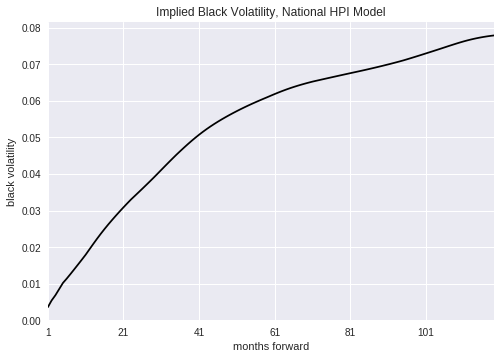

In [3]:
bv.loc['USA'].plot(color = 'k')
plt.xlabel('months forward')
plt.ylabel('black volatility')
plt.title('Implied Black Volatility, National HPI Model')
plt.show()

For comparison, we include implied BV calculations with interest rates at historical levels, which were more volatile than they are today.

In [4]:
bv_hist_rates = pd.read_csv('black_vols_hist_rates.csv', header=0, index_col=0)
bv_hist_rates.head()

,1,2,3,4,5,6,7,8,9,10,...,110,111,112,113,114,115,116,117,118,119
0,,,,,,,,,,,,,,,,,,,,,
USA,0.003579,0.005419,0.006843,0.008514,0.010202,0.011421,0.012744,0.014119,0.015522,0.016947,...,0.076442,0.076751,0.07704,0.077306,0.077550,0.077771,0.077970,0.078146,0.078302,0.078438
AK,0.003579,0.005419,0.006843,0.008514,0.010202,0.011421,0.012744,0.014119,0.015522,0.016947,...,0.076442,0.076751,0.07704,0.077306,0.077550,0.077771,0.077970,0.078146,0.078302,0.078438
AL,0.003579,0.005419,0.006843,0.008514,0.010202,0.011421,0.012744,0.014119,0.015522,0.016947,...,0.076442,0.076751,0.07704,0.077306,0.077550,0.077771,0.077970,0.078146,0.078302,0.078438
AR,0.003579,0.005419,0.006843,0.008514,0.010202,0.011421,0.012744,0.014119,0.015522,0.016947,...,0.076442,0.076751,0.07704,0.077306,0.077550,0.077771,0.077970,0.078146,0.078302,0.078438
AZ,0.012758,0.018256,0.020053,0.023832,0.027998,0.029837,0.032086,0.034477,0.036880,0.039251,...,0.190876,0.191789,0.19271,0.193637,0.194573,0.195521,0.196484,0.197465,0.198469,0.199501


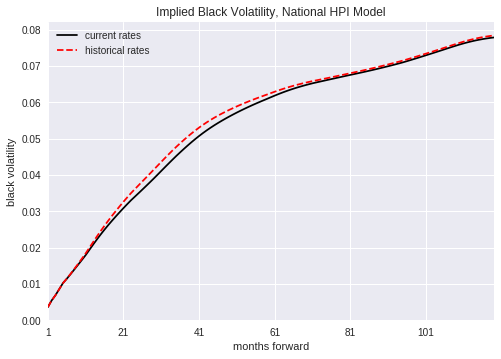

In [5]:
bv.loc['USA'].plot(color = 'k', label = 'current rates')
bv_hist_rates.loc['USA'].plot(color = 'r', linestyle = '--', label = 'historical rates')
plt.xlabel('months forward')
plt.ylabel('black volatility')
plt.legend(loc = 2)
plt.title('Implied Black Volatility, National HPI Model')
plt.show()

It turns out that modeling HPI off of historical rates does not appreciable affect volatility. (The national index was fairly representative of the whole batch in this respect.)

We will compare these volatility projections against historical levels. 

When calculating *empirical* Black volatility, we take a slightly different approach. We can't treat historical HPI as a stochastic process in the same way as a projection--there's no meaningful way to conceive of variance and expected value of historically realized HPI--but we can derive volatility with a slightly different approach. 

Let $X_t$ denote log-HPI at time $t$. Then, discretizing our closed SDE,
$$ \Delta X_t = (\mu - \frac{\sigma^2}{2}) \Delta t + \sigma \Delta W_t.$$

Then $$\mbox{Var}(\Delta X_t) = 0 + \mbox{Var}(\sigma \Delta W_t) = \sigma_{avg}^2 \mbox{Var}(\Delta W_t).$$ But $$\mbox{Var}(\Delta W_t) = \Delta t,$$ so
$$\sigma_{avg} = \frac{\mbox{Sd}(\Delta X_t)}{\sqrt{\Delta t}}.$$

We have now found a formulation of empirical (average) volatility as a function of $\Delta t.$ Let $\tau$ be a time horizon (e.g., 12 months forward). Then $$\sigma_{avg}(\tau) = \mbox{Sd}\left(\frac{X(t+\tau)}{X(t)}\right) / \sqrt{\tau},$$ where again $X(t) = X_t$ is the log value of HPI at time $t.$

In practice, we calculate empirical volatility on a definite window, e.g. over five years, over a historical time series of greater length. In the following computation, we make use of historical HPI data for each index from 1990 to 2015. Thus, in deriving five year volatility, we take the standard deviation of $\Delta X_t)$ with respect to the numerous overlapping 60-month windows of a time series of (up to) 300 observations. Because these windows overlap, 'raw' standard deviation will be too low, so we multiply by the following degrees-of-freedom adjustment, $$k = \sqrt{\frac{N}{N-T}},$$ where $N$ is the total number of observations and $T$ is the length of the window, the volatility timeframe. 

One challenge that we face is that *seasonality* affects HPA. For small $\tau$, seasonality will factor sustantially (or perhaps principally) to empirical volatility. We will get around this difficulty by restricting $\tau$ to yearly intervals, i.e. multiples of twelve in a monthly time series. 

In [6]:
hist_hpi = pd.read_csv('historical_HPI.csv', index_col=0).transpose()

In [7]:
hist_hpi.head()

,1,2,3,4,5,6,7,8,9,10,...,297,298,299,300,301,302,303,304,305,306
USA,98.40,98.60,98.70,98.80,98.90,99.20,99.50,99.70,99.50,99.20,...,214.00,213.80,213.60,213.90,214.20,214.60,215.70,216.90,218.10,219.10
AK,78.94,77.18,81.58,85.98,90.38,93.38,96.38,99.38,97.74,96.09,...,242.11,242.72,243.33,242.35,241.37,240.39,241.93,243.46,244.99,246.16
AL,98.03,97.65,98.06,98.48,98.90,98.96,99.03,99.10,99.07,99.03,...,193.31,195.13,196.95,193.94,190.93,187.92,189.20,190.48,191.76,192.42
AR,98.56,98.87,98.74,98.62,98.50,98.93,99.37,99.80,99.39,98.99,...,195.80,196.82,197.84,195.56,193.29,191.02,192.20,193.39,194.58,195.27
AZ,99.21,99.25,98.90,98.56,98.21,98.66,99.12,99.58,99.02,98.46,...,239.94,240.08,240.22,242.58,244.95,247.31,248.30,249.29,250.27,251.46


We can now make some comparisons between empirical, historical HPI volatility and the implied volatility in our HPI model. 

In [8]:
#hpi_array should be a 1-D record of housing price movement. This measure of volatility is starting-point neutral.
#span should be an integer, the number of months over which to calculate volatility
#obsv_span should be an integer, greater than span, less than len(hpi_array). 
# In months, gives the underlying timespan for making calculations.
#calculates 'historical' black volatility
def black_volatility(hpi_array, span, obsv_span):
    l = len(hpi_array)
    assert obsv_span > span
    assert obsv_span + span <= l - 1
    dof_adjust = np.sqrt(obsv_span / (obsv_span - span))
    year_intervals = [i for i in range(1,span+1) if i%12==0] 
    vol_list = []
    for tau in year_intervals:
        log_growths = []
        for t in range(l - obsv_span - span, l - span):
            log_growths.append(np.log(hpi_array[t + tau]/ hpi_array[t]))
        x = np.var(log_growths) / (tau / 12.0)
        vol_list.append(dof_adjust * np.sqrt(x))
    return np.asarray(vol_list)

In [9]:
def write_hist_vol_frame(N,T):
    frame = pd.DataFrame(index = bv.index, columns = [i for i in range(1,T+1) if 12*i <= T])
    for location in frame.index:
        hpi_array = np.asarray(hist_hpi.loc[location])
        frame.loc[location] = black_volatility(hpi_array, T, N)
    return frame

In [10]:
hist_bvs = write_hist_vol_frame(245,60)
hist_bvs.head()

,1,2,3,4,5
0,,,,,
USA,0.0482871,0.064892,0.0742315,0.0788884,0.0800537
AK,0.039016,0.0435216,0.04824,0.0510428,0.051882
AL,0.0358271,0.0462404,0.0516312,0.05358,0.0529457
AR,0.0314571,0.0392203,0.0443135,0.046629,0.046474
AZ,0.110648,0.14412,0.159154,0.161031,0.153681


In [11]:
hist_bvs.to_csv('5yr_bv_emp.csv')

In [12]:
#N corresponds to underyling calc range of empirical bv.
#T corresponds to number of months for which bv is calculated.
def vol_demo(N,T):
    y1 = range(1, T/12 + 1)
    y2 = np.linspace(0,T/12.0,T) + 1/12.0
    tuples = [(0,4), (5,10), (35,6), (23,44)]
    for pair in tuples:
        state1 = hist_hpi.index[pair[0]]
        state2 = hist_hpi.index[pair[1]]
        plt.figure(figsize = (20,4))
        
        plt.subplot(1,2,1)
        arr = hist_hpi.loc[state1].get_values()
        hist_bv =  black_volatility(arr, T, N)
        est_bv = bv.loc[state1].get_values()[0:T]
        plt.scatter(y1, hist_bv, color = 'k', marker = 'x', label = 'empirical') 
        plt.plot(y2, est_bv, color = 'r', linestyle = '--', label = 'modeled')
        plt.xlim(0,(T+1)/12.0)
        plt.xlabel('years forward')
        plt.ylabel('Black volatility')
        plt.ylim(0, 0.2)
        plt.legend(loc=2)
        plt.title('Comparison of Empirical and Modeled Volatility in ' + state1)
        
        
        plt.subplot(1,2,2)
        arr = hist_hpi.loc[state2].get_values()
        hist_bv =  black_volatility(arr, T, N)
        est_bv = bv.loc[state2].get_values()[0:T]
        plt.scatter(y1, hist_bv, color = 'k', marker = 'x', label = 'empirical') 
        plt.plot(y2, est_bv, color = 'r', linestyle = '--', label = 'modeled')
        plt.xlim(0,(T+1)/12.0)
        plt.xlabel('years forward')
        plt.ylabel('Black volatility')
        plt.ylim(0, 0.2)
        plt.legend(loc=2)
        plt.title('Comparison of Empirical and Modeled Volatility in ' + state2)
        
        plt.show()

In [ ]:
['Oakland-Fremont-Hayward, CA  (MSAD)', 'San Jose-Sunnyvale-Santa Clara, CA', 'San Francisco-San Mateo-Redwood City, CA  (MSAD)']

'Albany-Schenectady-Troy, NY'

In [17]:
def vol_demo1(N,T):
    y1 = range(1, T/12 + 1)
    y2 = np.linspace(0,T/12.0,T) + 1/12.0
    for state1 in ['Oakland-Fremont-Hayward, CA  (MSAD)', 'San Jose-Sunnyvale-Santa Clara, CA', 'San Francisco-San Mateo-Redwood City, CA  (MSAD)']:
        arr = hist_hpi.loc[state1].get_values()
        hist_bv =  black_volatility(arr, T, N)
        est_bv = bv.loc[state1].get_values()[0:T]
        plt.scatter(y1, hist_bv, color = 'k', marker = 'x', label = 'empirical') 
        plt.plot(y2, est_bv, color = 'r', linestyle = '--', label = 'modeled')
        plt.xlim(0,(T+1)/12.0)
        plt.xlabel('years forward')
        plt.ylabel('Black volatility')
        plt.ylim(0, 0.2)
        plt.legend(loc=2)
        plt.title('Comparison of Empirical and Modeled Volatility in ' + state1)
        
        plt.show()

We display comparison of real and projected volatility for HPI nationally, in the four states containing our four non-composite core indicies, and three 'problematic' states. 

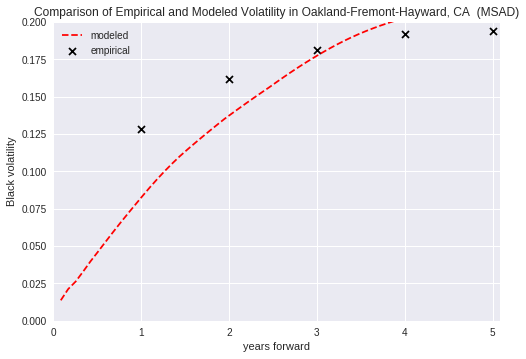

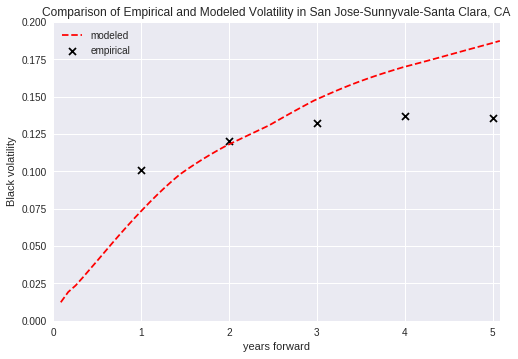

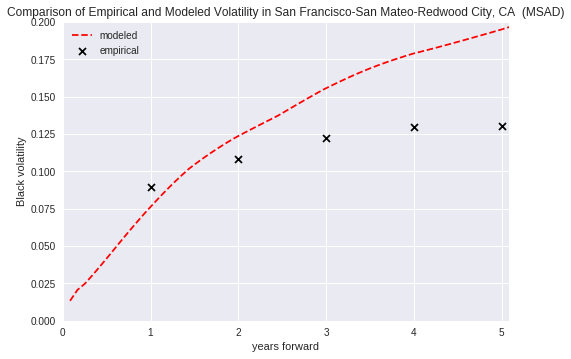

In [18]:
vol_demo1(245,60)

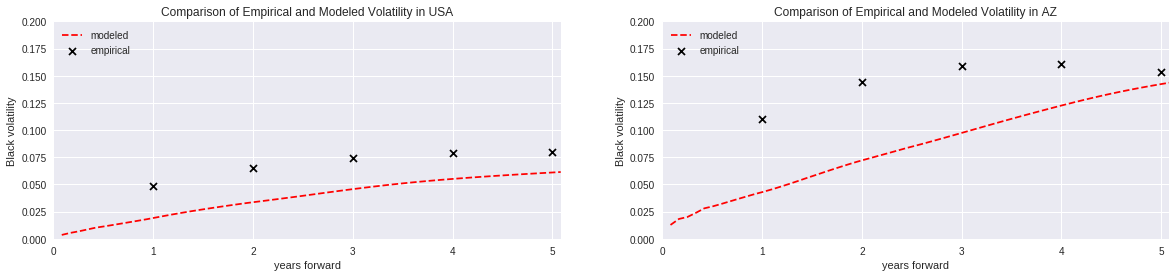

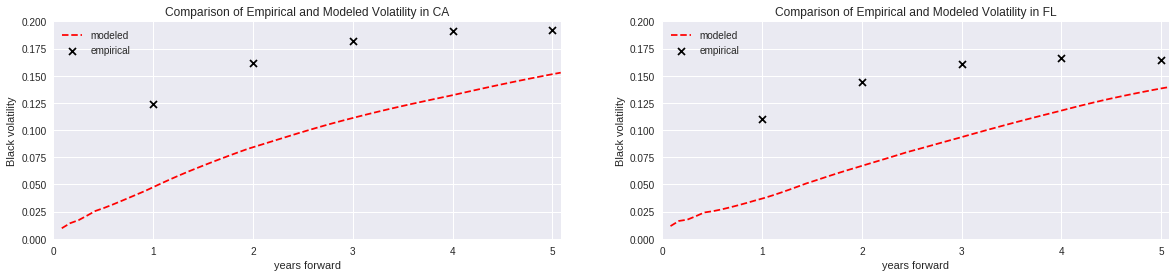

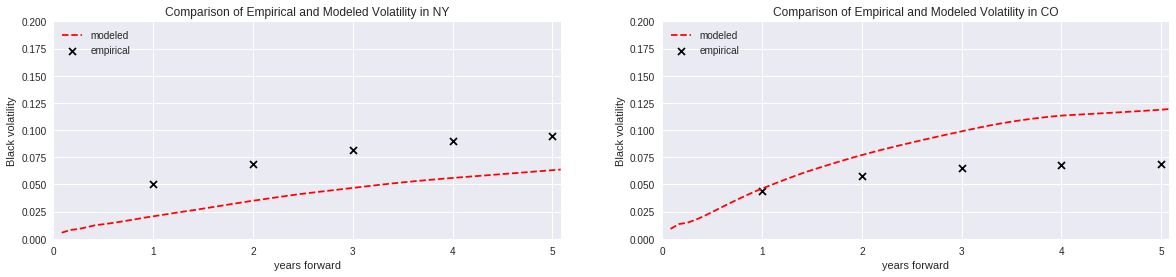

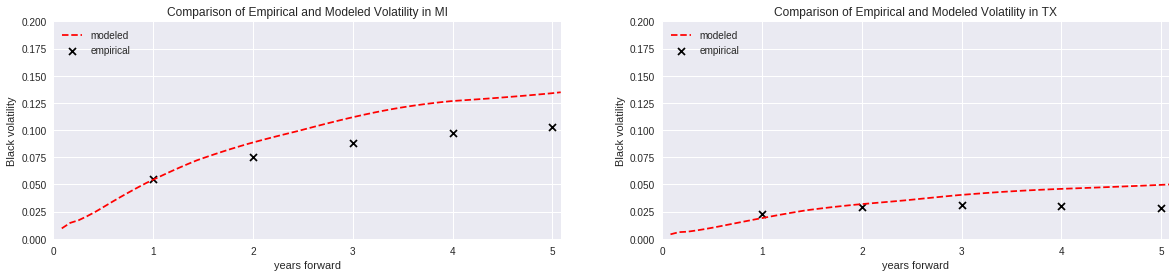

In [35]:
vol_demo(245, 60)

On average, the HPI model has lower volatility than what has been the case historically: the historical data includes the housing boom-and-bust of the financial crisis, while the HPI model does not attempt to include factors of 'artificial affordability' (which explains the crisis pretty well) in its forecast. 

We included Colorado, Michigan, and Texas in the sampling above because they behave problematically in the HPI model: their modeled volatilities exceed the historical norm. 

In [28]:
#vol_demo1(245,60)

One hypothesis for why volatility estimates can be too high for certain indicies lies in the linear regression approach of the HPI localizer. 

For reference, here are the coefficients on the core indices for each of the above states.

In [20]:
coefs = pd.read_csv('localizer_coefs.csv', index_col=0)
coefs['euc norm'] = coefs.apply(np.linalg.norm, raw = True, axis = 1)
coefs.loc[['US', 'AZ','CA','FL', 'NY', 'CO', 'MI', 'TX']]

,Comp,LA,MIA,NY,PX,alpha,euc norm
US,0.727,-0.174,-0.004,-0.017,0.091,-0.006554,0.753282
AZ,0.000,-0.069,0.000,0.205,0.833,-0.003162,0.860631
CA,1.368,0.421,0.110,-0.472,-0.091,-0.003090,1.513882
FL,0.000,0.040,0.503,0.213,0.236,-0.007039,0.596426
NY,0.000,0.069,-0.090,0.725,-0.004,-0.005082,0.733845
CO,2.660,-0.956,-0.115,-0.809,-0.088,0.013389,2.943665
MI,3.135,-0.798,-0.310,-1.087,-0.054,-0.011898,3.427208
TX,0.948,-0.241,-0.230,-0.312,0.098,-0.003706,1.056715


In [70]:
coefs['euc norm'].iloc[:52].sort_values(ascending=False).head(10)

MI    3.427208
CO    2.943665
MN    2.100381
MA    2.036093
GA    1.834789
OH    1.741402
NH    1.589673
CA    1.513882
NE    1.476724
IN    1.317520
Name: euc norm, dtype: float64

In [32]:
coefs.loc['41884']

Comp        3.774000
LA         -0.425000
MIA        -0.711000
NY         -1.184000
PX         -0.091000
alpha       0.019647
euc norm    4.042245
Name: 41884, dtype: float64

In [31]:
'41884' in coefs.iloc[52:].index

True

In [23]:
for code in coefs['euc norm'].iloc[52:].sort_values(ascending=False).head(20).index:
    if len(code) > 3:
        display(cbsa_decoder(code), coefs.loc[code, 'euc norm'])

'Detroit-Livonia-Dearborn, MI  (MSAD)'

4.7244990483741205

'Warren-Troy-Farmington Hills, MI  (MSAD)'

4.3428882006701297

'Oakland-Fremont-Hayward, CA  (MSAD)'

4.3166491726662857

'San Jose-Sunnyvale-Santa Clara, CA'

4.098359859118875

'San Francisco-San Mateo-Redwood City, CA  (MSAD)'

4.0422450460425638

'Denver-Aurora-Broomfield, CO'

3.6717933427919331

'Santa Rosa-Petaluma, CA'

3.5792154170008352

'Stockton, CA'

3.537645562114506

'Salinas, CA'

3.5123526787101054

'Greeley, CO'

3.403231925448218

'Ann Arbor, MI'

3.3883572732341949

'Boulder, CO'

3.3357134544590306

'Merced, CA'

3.2318014978361371

'Flint, MI'

3.2043483223866382

'Monroe, MI'

3.147525623040567

'Santa Cruz-Watsonville, CA'

3.0048726400049142

'Fort Collins-Loveland, CO'

2.9787000846505034

'Vallejo-Fairfield, CA'

2.9592134574886595

'Grand Rapids-Wyoming, MI'

2.8761232361331932

'Holland-Grand Haven, MI'

2.8761232361331932

In [22]:
cbsa_key = pd.read_csv('cbsa_key.csv', header = None, index_col=0)
def cbsa_decoder(code):
    return cbsa_key.loc[int(code), 1]
#for readability's sake, I decided to keep the numerical code as the sole index of the CBSA-level dataframe.
#this function lets the user switch from the code to the locality's name. A simple illustration: 

Observe that in the case of Colorado and Michigan, their coefficients on the first variable (the 25-MSA composite) is rather high, and overall their coefficients have large magnitude. The effect of this is to amplify the jumps, raising volatility. This doesn't explain the case of Texas, but it's possible that the state simply experienced unusually low housing volatility in recent history. 

We'll define "Volatility Quotient" as the ratio between historical (empirical) volatility and the calculation returned for the HPI model's projections. 

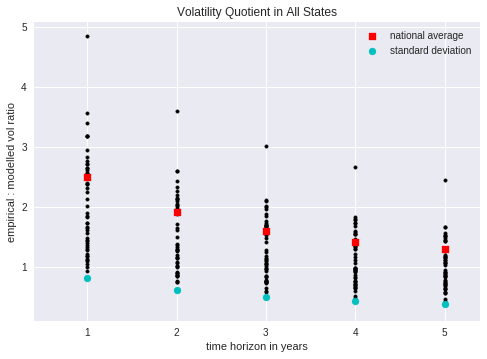

In [42]:
ratios = []
for state in hist_bvs.index[1:52]:
    emp = hist_bvs.loc[state].get_values()
    mod = bv.loc[state].get_values()[[12*i - 1 for i in range(1,6)]]
    plt.scatter(range(1,6), emp/mod, color = 'k', marker = '.')
    ratios.append(list(emp/mod))
emp = hist_bvs.loc['USA'].get_values()
mod = bv.loc['USA'].get_values()[[12*i - 1 for i in range(1,6)]]
sd = []
for column in np.asarray(ratios).transpose():
    sd.append(np.std(column))
plt.scatter(range(1,6), emp/mod, color = 'r', marker = 's', label = 'national average')
plt.scatter(range(1,6), sd, color = 'c', marker = 'o', label = 'standard deviation')
plt.xlabel('time horizon in years')
plt.legend(loc=1)
plt.xlim(0.4,5.4)
plt.ylabel('empirical : modelled vol ratio')
plt.title("Volatility Quotient in All States")
plt.show()

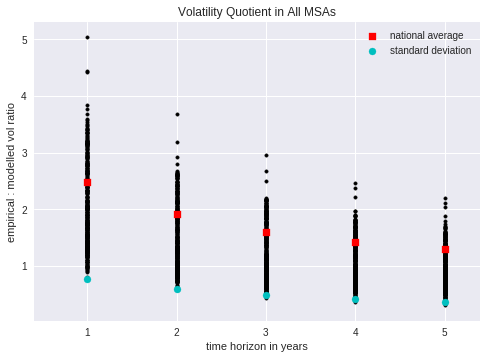

In [38]:
ratios = []
for state in hist_bvs.index[53:]:
    emp = hist_bvs.loc[state].get_values()
    mod = bv.loc[state].get_values()[[12*i - 1 for i in range(1,6)]]
    plt.scatter(range(1,6), emp/mod, color = 'k', marker = '.')
    ratios.append(list(emp/mod))
emp = hist_bvs.loc['USA'].get_values()
mod = bv.loc['USA'].get_values()[[12*i - 1 for i in range(1,6)]]
sd = []
for column in np.asarray(ratios).transpose():
    sd.append(np.std(column))
plt.scatter(range(1,6), emp/mod, color = 'r', marker = 's', label = 'national average')
plt.scatter(range(1,6), sd, color = 'c', marker = 'o', label = 'standard deviation')
plt.xlabel('time horizon in years')
plt.legend(loc=1)
plt.xlim(0.4,5.4)
plt.ylabel('empirical : modelled vol ratio')
plt.title("Volatility Quotient in All MSAs")
plt.show()

We should note that, in some ways, empirical HPI is an imperfect statistic, particularly for smaller regions: when there are fewer data points in a sample of home prices, we may see larger jumps. Equivalently, the effect of taking a large sample is to bring the sample average to a 'true' mean.

Thus the behavior of Hawaii, which is the outlying datum at the top of the first graph. The national average indicates that, over longer time horizons, empirical and modelled volatility approach each other. 